# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from d4pg_agent import D4PG_Agent
from params import Params
from logger import Logger
from CustomSummaryWriter import CustomSummaryWriter

In [ ]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [8]:
# WARN: SLOWS DOWN TRAINING ALOT..
# torch.autograd.set_detect_anomaly(True)
# np.seterr(all='raise')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [16]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.722786005702801


## Get a rough estimate of bounds of reward function, to init V_min and V_max

In [6]:
# NOTE: INTERRUPT KERNAL TO STOP ANALYSIS

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
max_reward = 0.0
min_reward = 0.0
max_action = 0.0
min_action = 0.0
eps_max = 1000
iters = 0

while iters < eps_max:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    
    # DEBUG: PLOT GRAPH OF REWARDS
    max_reward = max(rewards) if (max(rewards) > max_reward) else max_reward
    min_reward = min(rewards) if (min(rewards) < min_reward) else min_reward
    max_action = np.amax(actions) if (np.amax(actions) > max_action) else max_action
    min_action = np.amin(actions) if (np.amin(actions) < min_action) else min_action
    iters += 1
    print("\rEpisode: {} \tMAX REWARD: {:.2f} \tMIN REWARD: {:.2f} \tMAX ACTION: {:.2f} \tMIN ACTION: {:.2f}".format(iters, max_reward, min_reward, max_action, min_action), end="")

    
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step    
    #if np.any(dones):                                  # exit loop if episode finished
    #    break


Episode: 1000 	MAX REWARD: 1.39 	MIN REWARD: -1.48 	MAX ACTION: 4.67 	MIN ACTION: -5.00

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [6]:
def d4pg(params=Params(), logger=Logger()):

    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now() 
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
#     try:
    start_eps = params.eps_to_resume_from if not params.restart_training else 1        
    for i_episode in range(start_eps, params.n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        score = np.zeros(len(env_info.agents))

        for t in range(params.max_t):                             

            # REPORT NAN STATES
            if np.isnan(states).any():
                print('\nNaN found in states. Skipping this episode.')
                states = np.where(np.isnan(states), 0, states)
                states = next_states
                break

            # REPORT INF STATES
            if np.isinf(states).any():
                print('\nINF found in states. Skipping this episode.')
                states = np.where(np.isinf(states), 0, states)
                states = next_states
                break

            # Perform actions from each agent's policy network (clipped actions [0, -1])
            #actions = [ agent.act(state) for state in states ]  
            #actions = np.stack(actions)   
            actions = log_probs = values = []
            for state in states:
                action, log_prob, _, value = agent.act(state)
                actions.append(action)
                log_probs.append(log_prob)
                values.append(value)
            actions = np.stack(actions)
            log_probs = np.stack(log_probs)     
            values = np.stack(values)
            env_info = env.step(actions)[brain_name]      
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

            # REPORT NAN ACTIONS
            if np.isnan(actions).any():
                print('\nNaN found in actions. Skipping this episode.')
                actions = np.where(np.isnan(actions), 0, actions)
                states = next_states
                break

            # REPORT NAN ACTIONS
            if np.isinf(actions).any():
                print('\Inf found in actions. Skipping this episode.')
                actions = np.where(np.isinf(actions), 0, actions)
                states = next_states
                break

            # If rewards is super low / NaN for some reason, skip logging! (Prevent exploding gradients bug)
            low_rewards = np.array(rewards)<-30
            if any(low_rewards):                
                mean_low_rewards = np.array(rewards)[low_rewards].mean()
                print("Errorneously low Reward = {:.2f} Found! Doing nothing...".format(mean_low_rewards))
                print(rewards)
                # rewards = np.where(low_rewards, 0, rewards)
                print("SKIPPING TRAINING FOR THIS EPISODE")
                states = next_states
                break

            if np.isnan(rewards).any():
                print("NaN Reward Found! Skipping this episode.")
                rewards = np.where(np.isnan(rewards), -5.0, rewards)
                states = next_states
                break

            if np.isinf(rewards).any():
                print("Inf Reward Found! Skipping this episode.")
                rewards = np.where(np.isinf(rewards), -5.0, rewards)
                states = next_states
                break

            # Allow crawler to keep resetting if fall, but reset score to 0 if so
            agent.step(states, actions, rewards, log_probs, values, dones)
            states = next_states
            score += np.array(rewards)
            score = np.where(dones, 0, score)

            # Break if any of the agent is done
            if all(dones):   # any()
                break 

        # Learn from episode (add last state if using GAE)
        agent.add_last_state(next_states)
        agent.learn()
                
        # Print crucial results for progress tracking
        for i in range(len(agent.actor_losses)):
            logger.log_stats(i_episode, float(score.mean()), agent.actor_losses[i], agent.critic_losses[i], agent.entropy_losses[i])
        print('\rEpisode {}\ Score: {:.2f}'.format(i_episode, logger.scores_deque[-1]), end="")

        if i_episode % params.save_every == 0:
            logger.save_weights(i_episode)

        if i_episode % params.print_every == 0:
            print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAverage Score: {:.2f}\n'
                  .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque)))
            print('SCORES (this eps): ', score, '\n')
            logger.plot_categorical_probs()

            if np.mean(logger.scores_deque) >= params.target_score:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode, np.mean(logger.scores_deque)))
                if params.terminate_on_target_score:
                    break

    # Plot graphs & save final weights
    logger.save_weights(i_episode)
    if params.plot_stats:
        logger.plot_stats()
    logger.log_overall_perf_tb()
    total_train_duration(start_time=start_time, end_time=datetime.now())
    print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

#     # Catch any exceptions (Esp with keyboard interrupts)
#     except BaseException as error:
#         print('\n\n==== An exception occurred: {}'.format(error))
#         #logger.print_weights()
#         logger.save_weights(i_episode)
#         if params.plot_stats:
#             logger.plot_stats()
#         logger.log_overall_perf_tb()
#         total_train_duration(start_time=start_time, end_time=datetime.now())
#         print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return logger.scores_list


=============== NETWORKS ===============
actor_local Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=20, bias=True)
)
actor_target Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2

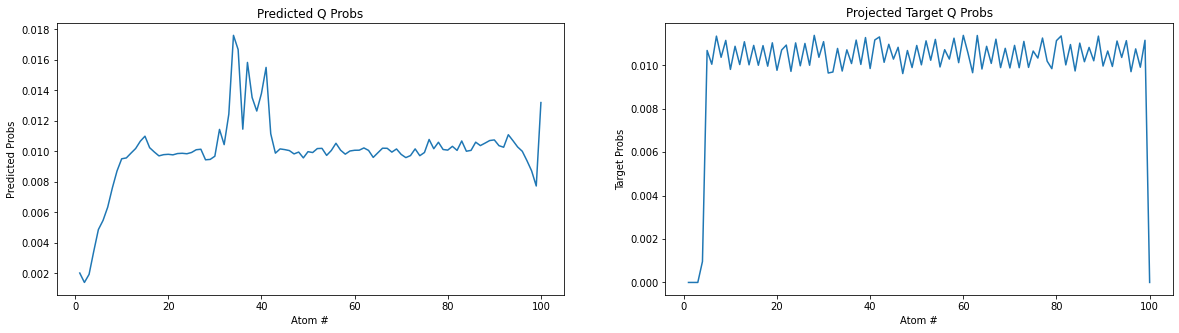

Episode 2: 	Actor Loss: -0.03 	Critic Loss: 4.23 
		Average Score: 1.10

SCORES (this eps):  [2.04376984 0.37930214 3.71700871 1.59062558 0.83585868 0.69401924
 0.12639123 1.55996018 0.14133302 0.29876158 1.16154776 0.65771124] 



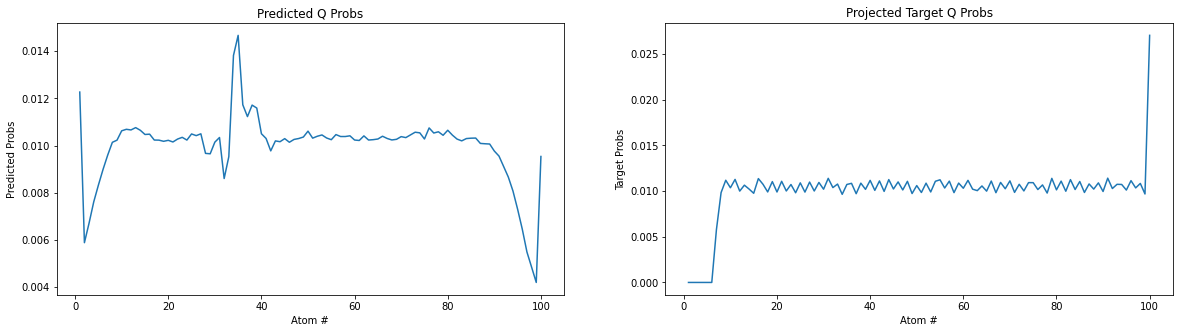

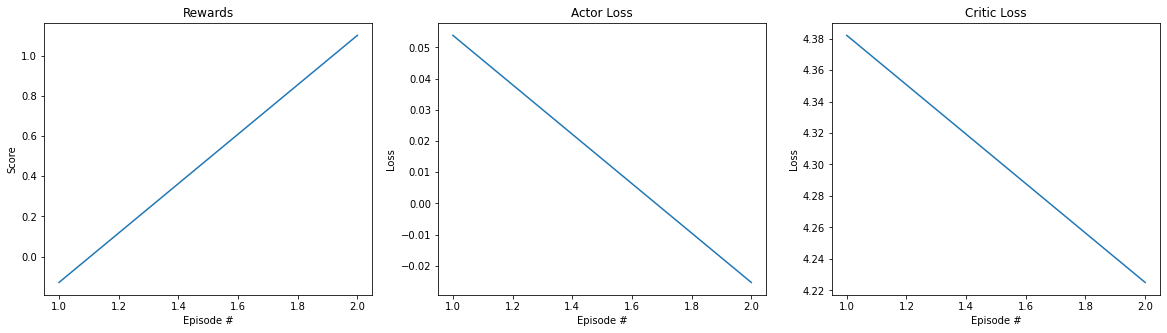

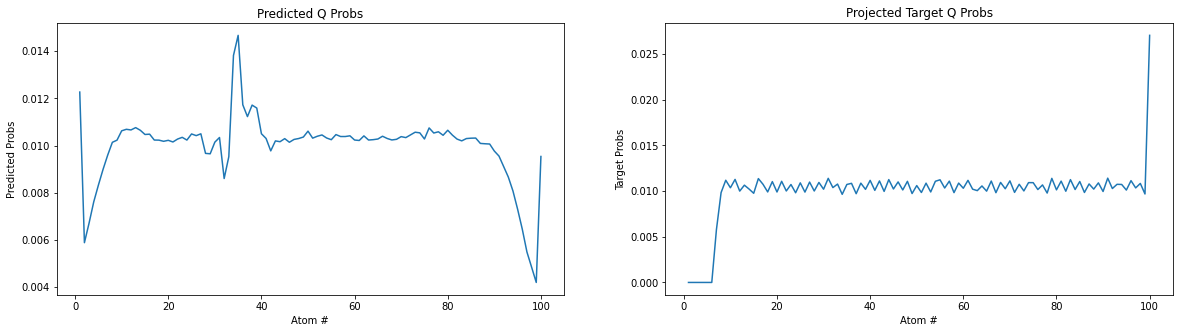

[-0.12839741197725138, 1.1005241002421826]

In [7]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=2
params.max_t = 50
params.print_every = 1
params.save_every = 1
params.log_weights_every = 1
params.prefill_memory_qty=0
params.terminate_on_target_score = True
params.target_score = 2500.0
params.plot_stats = True
params.batch_size = 32
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

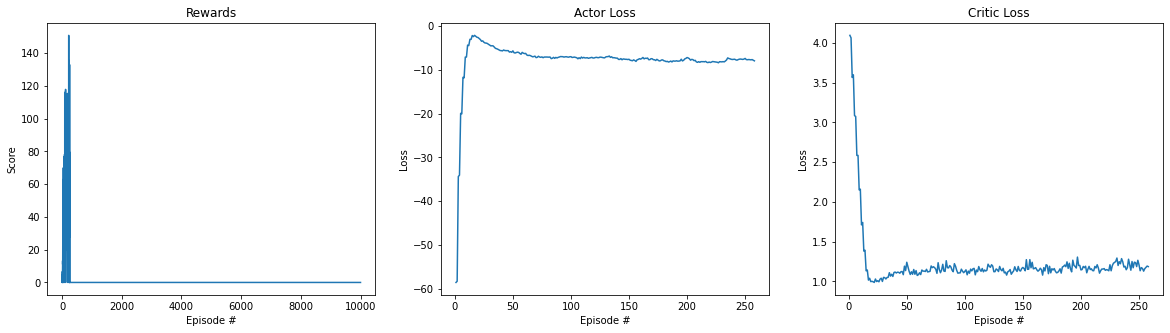

In [105]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [17]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_actor_ep300.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_critic_ep300.pth'))
max_t = 1000
score = np.zeros(len(env_info.agents))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
for i in range(max_t):
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    states = next_states                             # roll over the state to next time step
    
    # update the score
    score += np.array(rewards)                       
    score = np.where(dones, 0, score)
    
    # exit loop if episode finished (NOTE: Agents auto-restart upon done)
    #if all(dones):                                   
    #    break
    
print("Mean Score: {}".format(score.mean()))


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  -0.01
VMAX:  20
NUM_ATOMS:  100

Mean Score: 1088.789627775356


When finished, you can close the environment.

In [ ]:
# env.close()